### Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
# import powerlaw
import seaborn as sns

from collections import Counter
from general_functions import atw_title, cor_title, General, SENT_BEG, SENT_END, ttl_title 
from gensim.models import Word2Vec
from scipy.stats import gaussian_kde, linregress
from sklearn.manifold import TSNE
from typing import Final

In [2]:
gen = General()

### Read data

Read data:

In [3]:
ttl_sents = gen.read_from_pickle('./Pickles/ttl_sents.pickle')
ttl_counts = gen.read_from_pickle('./Pickles/ttl_counts.pickle')

atw_sents = gen.read_from_pickle('./Pickles/atw_sents.pickle')
atw_counts = gen.read_from_pickle('./Pickles/atw_counts.pickle')

cor_sents = gen.read_from_pickle('./Pickles/cor_sents.pickle')
cor_counts = gen.read_from_pickle('./Pickles/cor_counts.pickle')

### Sentence Metrics

* Number of sentences
* Mean and median sentence lengths
* Min and max sentence lengths

In [4]:
def sentence_metrics(sentences: list, name, minus = 2) -> None:
    """Calculate sentence metrics, and plot them
    Parameters:
        sentences (list): a list of tokens in each sentence
        name (str): the name of the text
        minus (int): number of words to ignore per sentence (default: 2 i.e. <s> and </s>)
    Returns:
        None"""
    
    words = []
    
    for sentence in sentences:
        words.append(len(sentence) - minus)
        
    words = pd.Series(words)
        
    print('Number of sentences:', len(sentences))
    print('Mean length of a sentence:', np.mean(words))
    print('Median length of a sentence:', np.median(words))
    print('Max sentence length:', words.max())
    print('Min sentence length:', words.min())
    
    fig = plt.figure(figsize = (12, 8))
    plt.plot(range(1, len(sentences) + 1), words, alpha = 0.5, color = '#00788c', label = 'Number of words')
    plt.plot(range(1, len(sentences) + 1), words.rolling(100).mean(), color = '#552583', label = '100-sentence rolling avg.')
    plt.title('Sentence Lengths: {}'.format(name))
    plt.xlabel('Sentence')
    plt.ylabel('Number of Words')
    plt.legend()
    plt.show()
    plt.close()
    
#     plt.hist(words, bins = 40, density = True, log = True, color = '#00788c')
    sns.displot(words, kind = 'kde', color = '#552583')
#     plt.yscale('log')
    plt.title('Words per Sentence KDE: {}'.format(name))
    plt.xlabel('Words')
    plt.ylabel('')
    plt.show()
    plt.close()

Number of sentences: 6587
Mean length of a sentence: 15.815090329436769
Median length of a sentence: 14.0
Max sentence length: 181
Min sentence length: 1


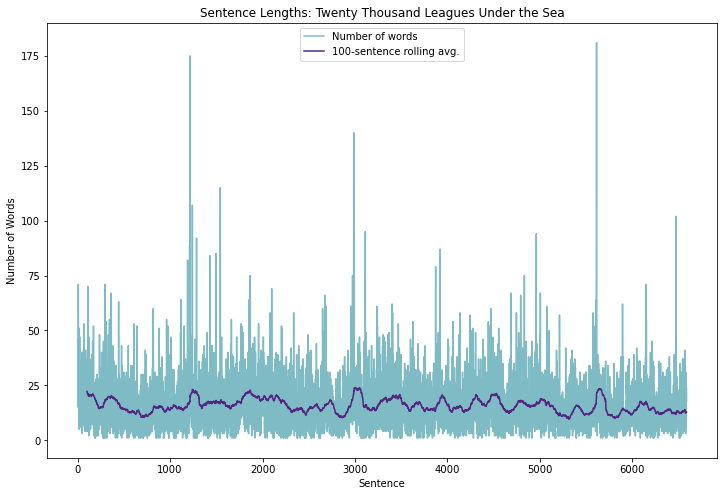

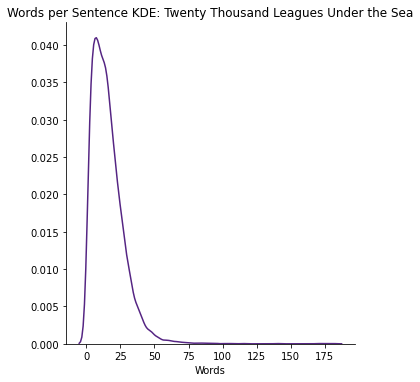

In [5]:
sentence_metrics(ttl_sents, ttl_title)

Number of sentences: 2876
Mean length of a sentence: 22.374826147426983
Median length of a sentence: 20.0
Max sentence length: 176
Min sentence length: 0


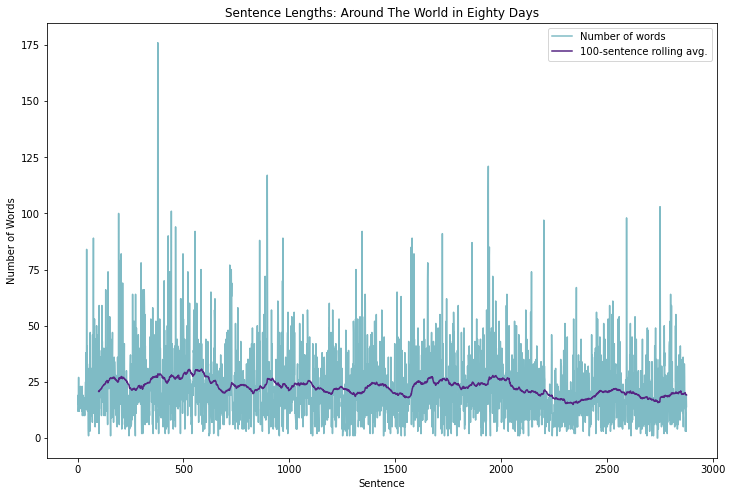

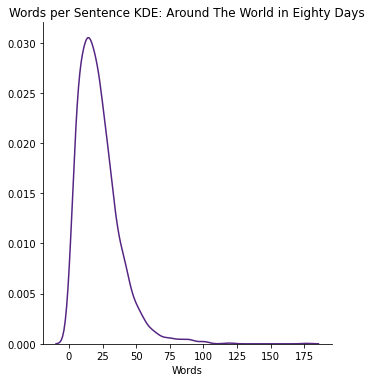

In [6]:
sentence_metrics(atw_sents, atw_title)

Number of sentences: 9463
Mean length of a sentence: 17.80872873295995
Median length of a sentence: 15.0
Max sentence length: 181
Min sentence length: 0


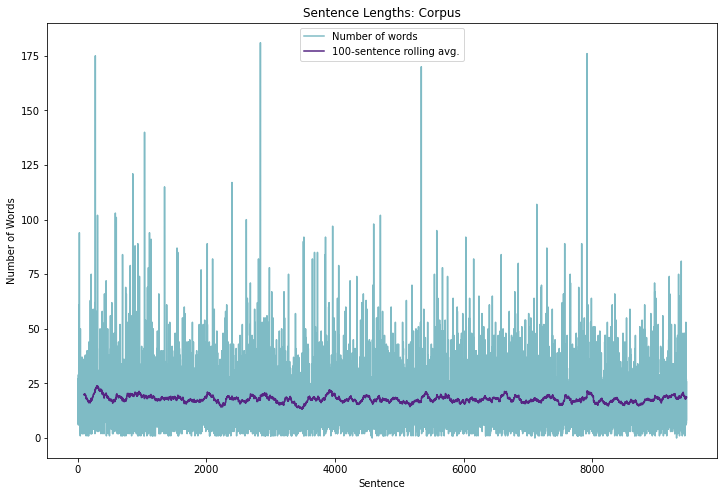

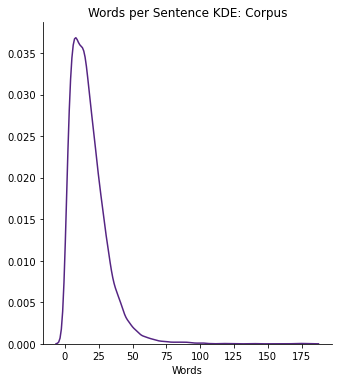

In [7]:
sentence_metrics(cor_sents, cor_title)

### Vocabulary Stats

In [8]:
def check_word(word) -> bool:
    """Check if a word is in a 'blacklist'
    Parameters:
        word (str): the word to check
    Returns:
        bool: whether of not the word is in the list"""
    
    if word in [SENT_BEG, SENT_END]:
        return True
    
    return False

#### Heaps' Law

In [9]:
def heaps_law(sentences: list, name) -> None:
    """Plot Heaps' Law for a list of sentences
    Parameters:
        sentences (list): a list of tokens in each sentence
        name (str): the name of the text
    Returns:
        None"""
    
    vocab, vocab_growth = set(), []
    word_count = 0
    
    for sentence in sentences:
        for word in sentence:
            
            # if word is not in the blacklist
            if not check_word(word):
                word_count += 1
                
                # if the word is unseen, add 1 to the growth count and add the word to the vocab
                if word not in vocab:
                    vocab.add(word)
                    vocab_growth.append(1)
                    
                # if the word has been seen, add 0 to the growth count
                else:
                    vocab_growth.append(0)
                    
    vocab_growth = pd.Series(vocab_growth)
    
    print('|V| = K * N ^ B i.e. log|V| = logK + BlogN')
    print('Vocab size |V|:', len(vocab))
    print('Word Count N:', word_count)
    
    x = np.array([i for i in range(1, word_count + 1)])
    vocab_growth_cumsum = vocab_growth.cumsum()
    
    # get slope and intercept from observations
    res = linregress(x = np.log10(x), y = np.log10(vocab_growth_cumsum))
    print('Predicted K:', 10 ** res.intercept)
    print('Predicted B:', res.slope)
    
    pred = (res.slope * np.log10(x)) + res.intercept  # calculated predicted |V|
    
    fig = plt.figure(figsize = (12, 8))
    plt.plot(x, vocab_growth_cumsum, color = '#552583', label = 'Observed')
    plt.plot(x, 10 ** pred, color = '#00788c', ls = '--', label = 'Predicted')
    plt.title("Heaps' Law: {}".format(name))
    plt.xlabel('Total Words Seen N')
    plt.ylabel('Vocabulary Size |V|')
    plt.legend()
    plt.show()
    plt.close()
    
    fig = plt.figure(figsize = (12, 8))
    plt.plot(np.log10(x), np.log10(vocab_growth_cumsum), color = '#552583', label = 'Observed')
    plt.plot(np.log10(x), pred, color = '#00788c', ls = '--', label = 'Predicted')
#     plt.xscale('log')
#     plt.yscale('log')
    plt.title("Heaps' Law (Log Scale): {}".format(name))
    plt.xlabel('Log Total Words Seen N')
    plt.ylabel('Log Vocabulary Size |V|')
    plt.legend()
    plt.show()
    plt.close()

|V| = K * N ^ B i.e. log|V| = logK + BlogN
Vocab size |V|: 8668
Word Count N: 104174
Predicted K: 7.533291243226517
Predicted B: 0.6172358549580007


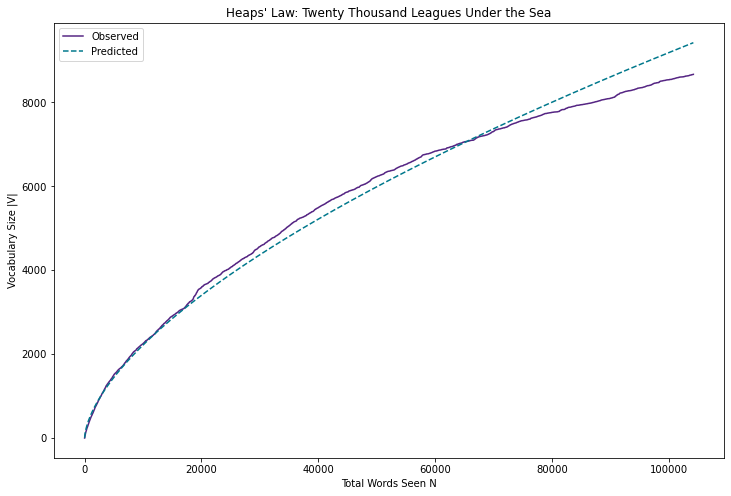

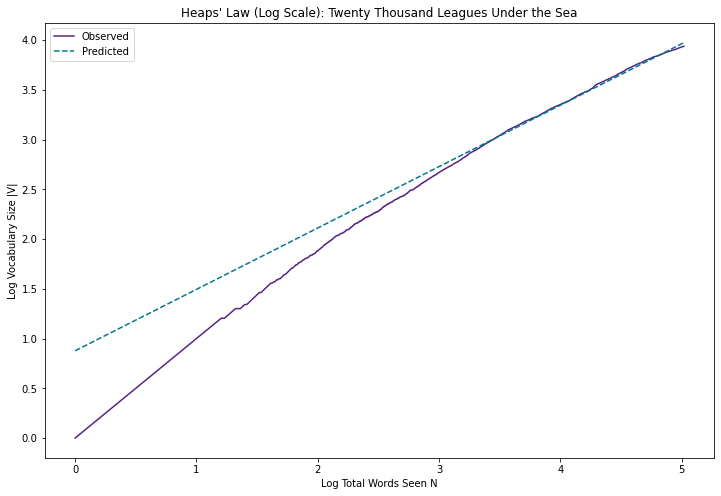

In [10]:
heaps_law(ttl_sents, ttl_title)

|V| = K * N ^ B i.e. log|V| = logK + BlogN
Vocab size |V|: 6850
Word Count N: 64350
Predicted K: 5.487115011141678
Predicted B: 0.6519176998807465


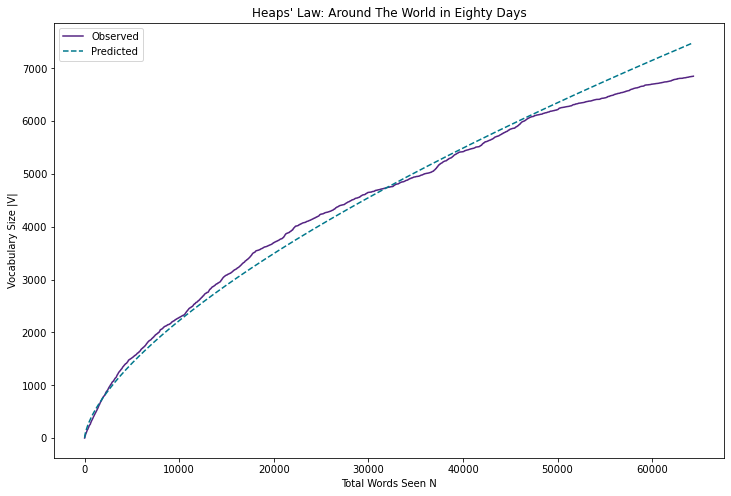

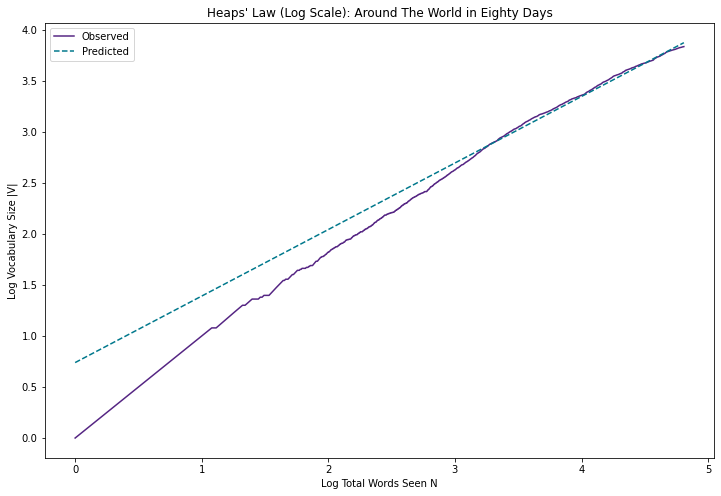

In [11]:
heaps_law(atw_sents, atw_title)

|V| = K * N ^ B i.e. log|V| = logK + BlogN
Vocab size |V|: 11576
Word Count N: 168524
Predicted K: 12.87336487137983
Predicted B: 0.5721789963070552


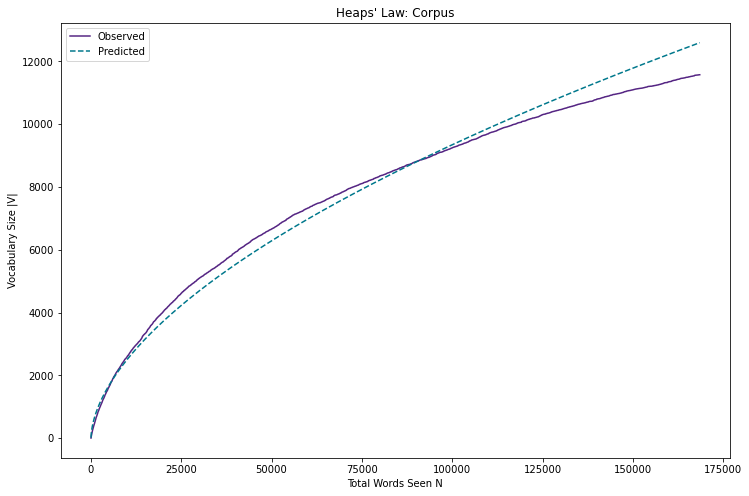

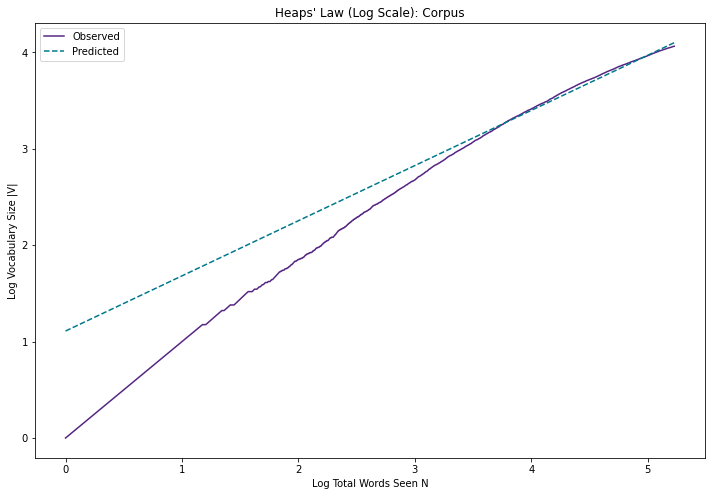

In [12]:
heaps_law(cor_sents, cor_title)

#### Zipf's Law

In [13]:
def zipfs_law(counts: Counter, name) -> None:
    """Plot Zipf's Law for a document or corpus
    Parameters:
        counts (Counter): token counts for the document/corpus
        name (str): the name of the text
    Returns:
        None"""
    
    freqs = np.array([wc[1] for wc in counts.most_common() if not check_word(wc[0])])
#     N = sum(freqs)
    
    print('F = K * R ^ -A i.e. logF = log K - AlogR')
    
    x = np.array([i for i in range(1, len(freqs) + 1)])
    
#     get slope and intercept from observations
    res = linregress(x = np.log10(x), y = np.log10(freqs))
    print('Predicted K:', 10 ** res.intercept)
    print('Predicted A:', res.slope)
    
    pred = (res.slope * np.log10(x)) + res.intercept  # calculated predicted F
    
    fig = plt.figure(figsize = (12, 8))
    plt.plot(np.log10(x), np.log10(freqs), color = '#552583', label = 'Observed')
    plt.plot(np.log10(x), pred, color = '#00788c', ls = '--', label = 'Predicted')
#     plt.xscale('log')
#     plt.yscale('log')
    plt.title("Zipf's Law: {}".format(name))
    plt.xlabel('Log Rank R')
    plt.ylabel('Log Frequency F')
    plt.legend()
    plt.show()
    plt.close()

F = K * R ^ -A i.e. logF = log K - AlogR
Predicted K: 38350.00857521534
Predicted A: -1.1886399270478594


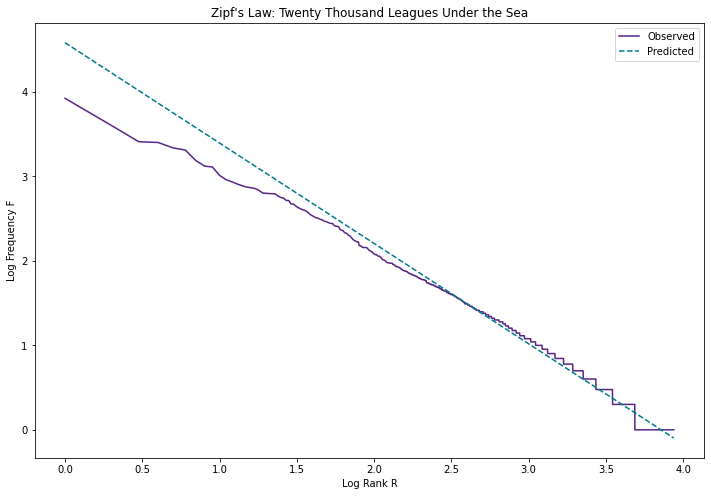

In [14]:
zipfs_law(ttl_counts, ttl_title)

F = K * R ^ -A i.e. logF = log K - AlogR
Predicted K: 15367.345632713721
Predicted A: -1.1196199859101177


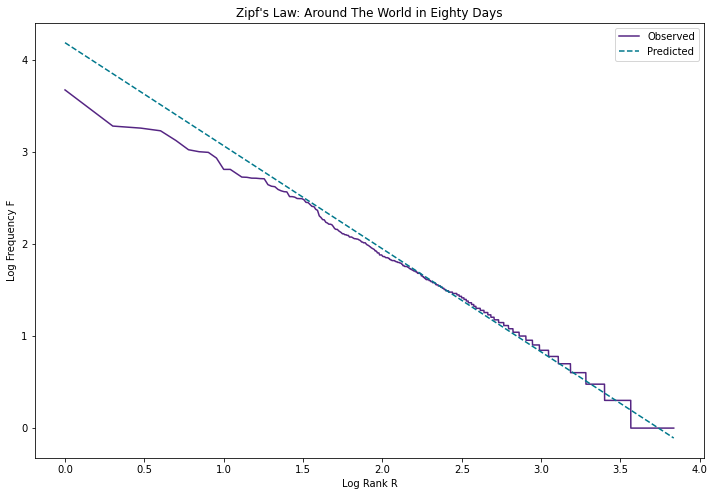

In [15]:
zipfs_law(atw_counts, atw_title)

F = K * R ^ -A i.e. logF = log K - AlogR
Predicted K: 88173.43204531026
Predicted A: -1.237795053775785


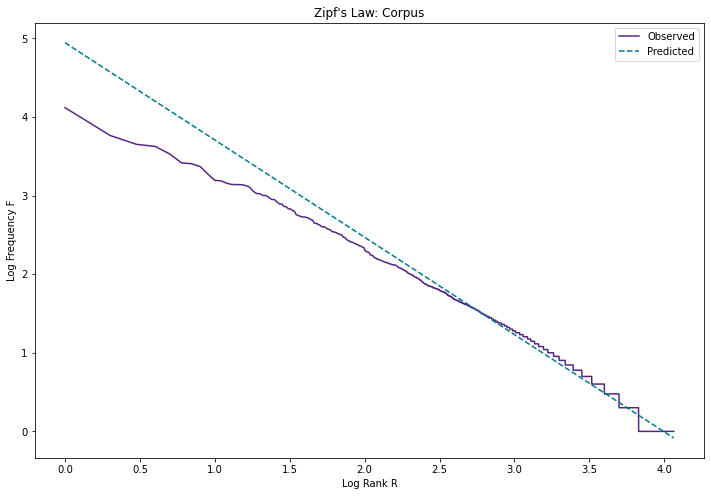

In [16]:
zipfs_law(cor_counts, cor_title)

#### Brevity Law (Zipf's Law of Abbreviation)

In [18]:
def brevity_law(counts: Counter, name) -> None:
    """Plot the Brevity Law for a document or corpus
    Parameters:
        counts (Counter): token counts for the document/corpus
        name (str): the name of the text
    Returns:
        None"""
    
    lens = np.array([len(w) for w in counts if not check_word(w)])
    freqs = np.array([counts[w] for w in counts if not check_word(w)])
    
    print('Mean word length:', np.mean(lens))
    print('Median word length:', np.median(lens))
    print('Max word length:', max(lens))
    print('Min word length:', min(lens))
    
#     fig = plt.figure(figsize = (12, 8))
#     plt.scatter(lens, np.log10(freqs), alpha = 0.5, color = '#552583')
#     plt.title('Brevity Law: {}'.format(name))
#     plt.xlabel('Word Length L')
#     plt.ylabel('Log Frequency F')
#     plt.show()
#     plt.close()
    
    xy = np.vstack([lens, freqs])
    z = gaussian_kde(xy)(xy)
    
    idx = z.argsort()
    lens, freqs, z = lens[idx], freqs[idx], z[idx]
    
    fig = plt.figure(figsize = (12, 8))
    sp = plt.scatter(lens, np.log10(freqs), c = z, cmap = 'cool')
    cbar = plt.colorbar(sp)
    plt.title('Brevity Law: {}'.format(name))
    plt.xlabel('Word Length L')
    plt.ylabel('Log Frequency F')
    cbar.set_label('KDE')
    plt.show()
    plt.show()
    plt.close()

#     fig = plt.subplots(figsize = (12, 8))
#     sns.displot(x = lens, y = np.log10(freqs), cmap = 'cool', cbar = True)
#     plt.title('Brevity Law: {}'.format(name))
#     plt.xlabel('Word Length L')
#     plt.ylabel('Log Frequency F')
#     plt.show()
#     plt.show()
#     plt.close()

Mean word length: 7.066912782648823
Median word length: 7.0
Max word length: 17
Min word length: 1


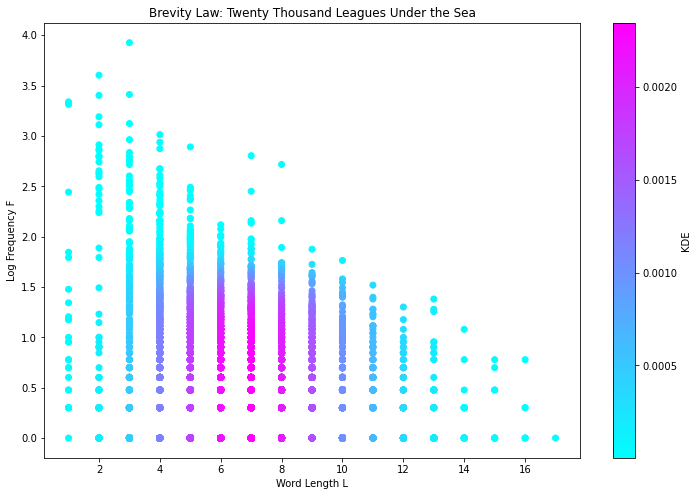

In [19]:
brevity_law(ttl_counts, ttl_title)  # add some lognormal plot?

Mean word length: 6.984525547445256
Median word length: 7.0
Max word length: 15
Min word length: 1


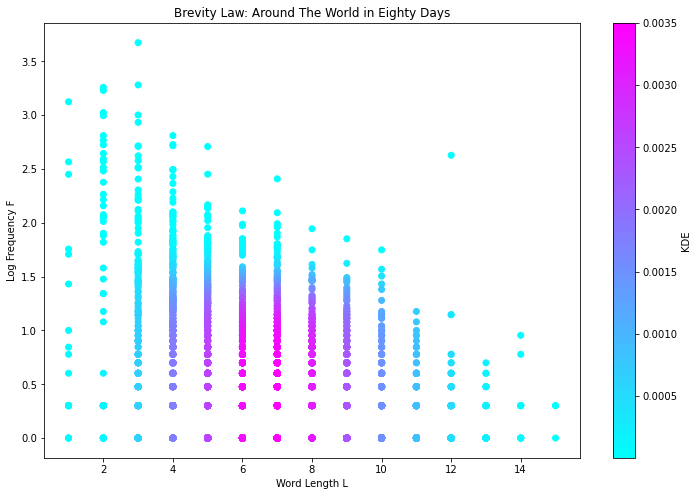

In [20]:
brevity_law(atw_counts, atw_title)

Mean word length: 7.174585348997927
Median word length: 7.0
Max word length: 17
Min word length: 1


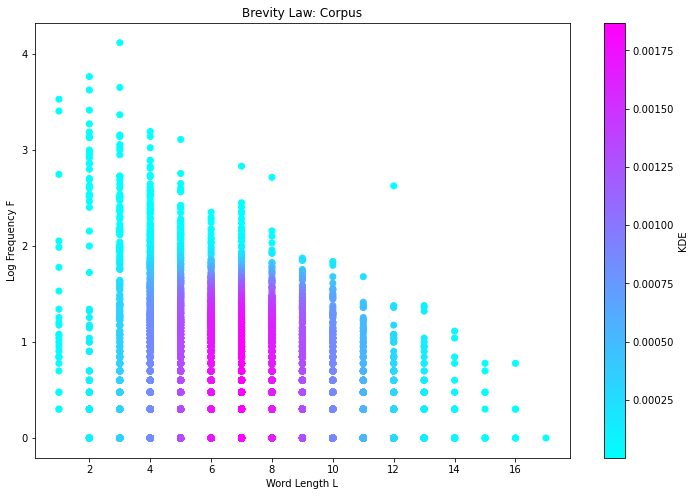

In [21]:
brevity_law(cor_counts, cor_title)

### Words as Vectors

#### Word2Vec creation

Create embeddings:

In [22]:
def create_word2vec(sentences: list, filepath = None, vector_size = 200, window = 5, sg = 1, min_count = 1) -> Word2Vec:
    """Create Word2Vec embeddings of a document/corpus
    Parameters:
        sentences (list): a list of tokens in each sentence
        filepath (str): the location to store the embeddings if not none (default: None)
        vector_size (int): the embedding dimension (default: 200)
        window (int): the max distance between the context word and target words (default: 5)
        sg (int): the flag for the training algorithm - skip-gram (1) or CBOW (0) (default: 1)
        min_count (int): the minimum frequency for a word to be considered (default: 1)
    Returns:
        Word2Vec: word embeddings"""
    
    model = Word2Vec(sentences = sentences, vector_size = vector_size, window = window, sg = sg, min_count = min_count)
    
    print('Vocab size |V|:', len(model.wv.index_to_key))
    
    if filepath:
        model.save(filepath + '_{}_{}.model'.format(vector_size, sg))
        
    return model

In [23]:
ttl_sg = create_word2vec(ttl_sents, filepath = './Word2Vec/ttl')

Vocab size |V|: 8670


In [24]:
atw_sg = create_word2vec(atw_sents, filepath = './Word2Vec/atw')

Vocab size |V|: 6852


Load saved embeddings:

In [22]:
def load_word2vec(filepath) -> Word2Vec:
    """Load Word2Vec embeddings
    Parameters:
        filepath (str): the location to load embeddings from
    Returns:
        Word2Vec: word embeddings"""
    
    model = Word2Vec.load(filepath)
    
    print('Vocab size |V|:', len(model.wv.index_to_key))
    
    return model

In [23]:
ttl_sg = load_word2vec('./Word2Vec/ttl_200_1.model')
atw_sg = load_word2vec('./Word2Vec/atw_200_1.model')

Vocab size |V|: 8670
Vocab size |V|: 6852


#### Analysing word vectors

In [24]:
def get_n_most_similar(model, token, n = 20) -> list:
    """Get the n most similar words of a token
    Parameters:
        model (Word2Vec): word embeddings model
        token (str): the target
        n (int): the max number of similar words to find (default: 20)
    Returns:
        list: a list of similar words with the token appended at the end"""
    
    if token in model.wv:
        word_list = [w for w, sim in model.wv.most_similar(token, topn = n)]
        word_list.append(token)
        
        return word_list
    
    return []

In [25]:
def get_vectors(model, token = None, n = 20, word_list = None, pplxty = 40, dims = 2) -> (np.array, list):
    """Get reduced-dimension projections of Word2Vec vectors using t-SNE
    If token is provided, the n most similar words are found, else the provided word_list is used
    Parameters:
        model (Word2Vec): word embediings model
        token (str): the target (default: None)
        n (int): the max number of similar words to find (default: 20)
        word_list (list): a list of words for which reduced-dim projections are found (default: None)
        pplxty (int): t-SNE perplexity (default: 40)
        dims (int): t-SNE reduction dimension (default: 2)
    Returns:
        np.array: reduced-dim embeddings
        list: a list of words for which reduced-dim projections are found"""
    
    if token:
        word_list = get_n_most_similar(model, token, n)
        
    if word_list and len(word_list) > 0:
        emb_vectors = [model.wv[w] for w in word_list]
        
        return TSNE(n_components = dims, perplexity = pplxty).fit_transform(emb_vectors), word_list
    
    return np.array([]), []

In [26]:
fogg_sim, fogg_words = get_vectors(atw_sg, token = 'fogg')

In [27]:
def plot_2D_embeddings(title, emb1, word_list1, target_token1 = True, emb2 = None, word_list2 = None, target_token2 = None) -> None:
    """Plot 2D word embeddings
    Parameters:
        title (str): plot title
        emb1 (np.array): first set of 2D embeddings
        word_list1 (list): list of words being plotted
        target_token1 (bool): wheter or not there is a target token for set 1 (default: True)
        emb2 (np.array): second set of 2D embeddings
        word_list2 (list): list of words being plotted
        target_token2 (bool): wheter or not there is a target token for set 2 (default: True)
    Returns:
        None"""
    
    fig = plt.figure(figsize = (12, 8))
    
    if target_token1:
        plt.scatter(emb1[: -1, 0], emb1[: -1, 1], color = '#552583', label = 'Similar words')
        plt.scatter(emb1[-1, 0], emb1[-1, 1], marker = 'x', s = 300, color = '#552583', label = word_list1[-1])
        plt.legend()
    else:
        plt.scatter(emb1[:, 0], emb1[:, 1], color = '#552583')

    x, y = emb1[:, 0], emb1[:, 1]
    for i, w in enumerate(word_list1):
        plt.annotate(w, xy = (x[i], y[i]), xytext = (5, 2), textcoords = 'offset points', ha = 'right', va = 'bottom', size = 8)
        
    if emb2:
        pass
        # to do
        
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()
    plt.close()

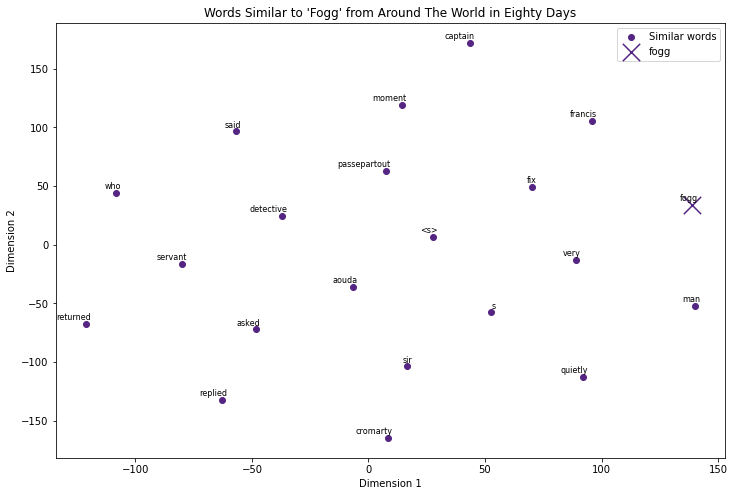

In [28]:
plot_2D_embeddings("Words Similar to 'Fogg' from {}".format(atw_title), fogg_sim, fogg_words)